In [6]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Load and preprocess
data = pd.read_csv("match_data_v5.csv")
data.columns = ["matchID", "blueTeamControlWardsPlaced", "blueTeamWardsPlaced", "blueTeamTotalKills", 
                "blueTeamDragonKills", "blueTeamHeraldKills", "blueTeamTowersDestroyed", 
                "blueTeamInhibitorsDestroyed", "blueTeamTurretPlatesDestroyed", "blueTeamFirstBlood", 
                "blueTeamMinionsKilled", "blueTeamJungleMinions", "blueTeamTotalGold", "blueTeamXp", 
                "blueTeamTotalDamageToChamps", "redTeamControlWardsPlaced", "redTeamWardsPlaced", 
                "redTeamTotalKills", "redTeamDragonKills", "redTeamHeraldKills", "redTeamTowersDestroyed", 
                "redTeamInhibitorsDestroyed", "redTeamTurretPlatesDestroyed", "redTeamMinionsKilled", 
                "redTeamJungleMinions", "redTeamTotalGold", "redTeamXp", "redTeamTotalDamageToChamps", 
                "blueWin", "empty"]
data = data.drop(columns=['matchID', 'empty']).dropna()

#Feature Engineering
data['totalKills'] = data['blueTeamTotalKills'] - data['redTeamTotalKills']
data['goldDiff'] = data['blueTeamTotalGold'] - data['redTeamTotalGold']
data['xpDiff'] = data['blueTeamXp'] - data['redTeamXp']
data['damageDiff'] = data['blueTeamTotalDamageToChamps'] - data['redTeamTotalDamageToChamps']
features = ['goldDiff', 'xpDiff', 'totalKills', 'damageDiff']
X = data[features].values
y = data['blueWin'].values

#K-nearest neighbors graph
k = 12  
knn_graph = kneighbors_graph(X, n_neighbors=k, mode='connectivity', include_self=False)
edges = knn_graph.nonzero()
edge_index = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

#Create Data object for PyTorch Geometric
graph_data = Data(x=x, edge_index=edge_index)

#Train-test split
train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_indices, dtype=torch.long)
test_mask = torch.tensor(test_indices, dtype=torch.long)

#Add masks to the Data object if needed
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

#GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = torch.nn.Linear(32, out_channels)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x

model = GCN(in_channels=x.size(1), out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

#train and test functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out[graph_data.train_mask], y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(graph_data)
        pred_probs = torch.sigmoid(out[graph_data.test_mask]).squeeze()  # Apply sigmoid
        pred = (pred_probs > 0.5).long()  # Convert predictions to binary
        true_labels = y[graph_data.test_mask].long()
        
        # Calculate accuracy
        acc = accuracy_score(true_labels.numpy(), pred.numpy())  # Use sklearn's accuracy_score
        acc_percentage = acc * 100 
        
        # Calculate precision
        precision = precision_score(true_labels.numpy(), pred.numpy())
        
    return acc_percentage, precision

#Lists to store accuracy and precision over epochs
accuracy_list = []
precision_list = []

#Train and evaluate the model
for epoch in range(1, 101):
    loss = train()
    acc_percentage, precision = test()
    
    # Append the accuracy and precision to the lists
    accuracy_list.append(acc_percentage)
    precision_list.append(precision)
    
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc_percentage:.2f}%, Precision: {precision:.4f}')

print("Training and evaluation complete.")




Epoch 001, Loss: 204.4942, Accuracy: 72.01%, Precision: 0.6906
Epoch 002, Loss: 124.2286, Accuracy: 72.65%, Precision: 0.7025
Epoch 003, Loss: 158.0125, Accuracy: 73.29%, Precision: 0.7107
Epoch 004, Loss: 152.8419, Accuracy: 73.52%, Precision: 0.7137
Epoch 005, Loss: 128.9435, Accuracy: 74.14%, Precision: 0.7191
Epoch 006, Loss: 97.9928, Accuracy: 73.85%, Precision: 0.7177
Epoch 007, Loss: 69.4068, Accuracy: 71.37%, Precision: 0.6919
Epoch 008, Loss: 52.8715, Accuracy: 61.86%, Precision: 0.5934
Epoch 009, Loss: 63.0655, Accuracy: 59.59%, Precision: 0.5804
Epoch 010, Loss: 63.3723, Accuracy: 64.38%, Precision: 0.6684
Epoch 011, Loss: 49.6093, Accuracy: 68.92%, Precision: 0.7828
Epoch 012, Loss: 44.1323, Accuracy: 70.46%, Precision: 0.7831
Epoch 013, Loss: 37.2622, Accuracy: 71.95%, Precision: 0.7721
Epoch 014, Loss: 31.8733, Accuracy: 72.09%, Precision: 0.7510
Epoch 015, Loss: 29.2263, Accuracy: 70.88%, Precision: 0.7051
Epoch 016, Loss: 26.7893, Accuracy: 64.87%, Precision: 0.6103
Epo

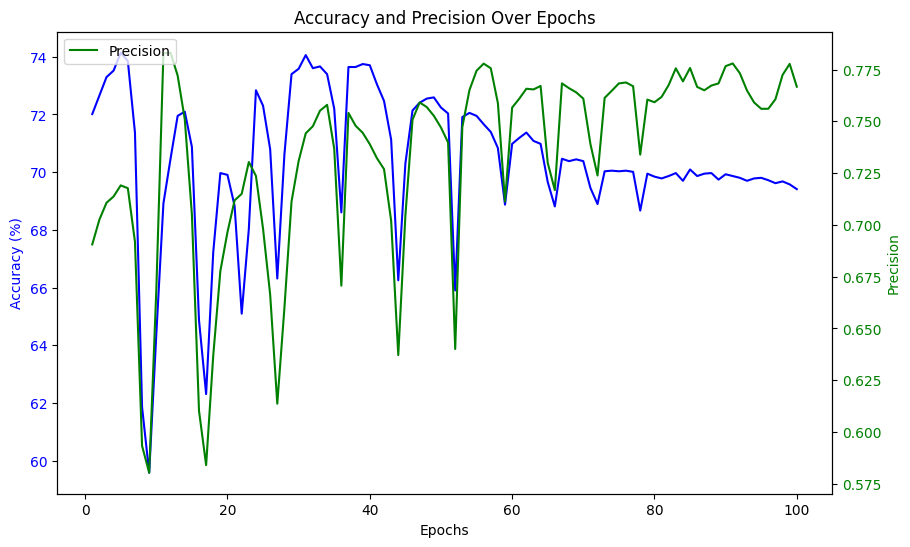

In [7]:
plt.figure(figsize=(10, 6))

#Plot accuracy
plt.plot(range(1, 101), accuracy_list, label='Accuracy (%)', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)', color='blue')
plt.tick_params(axis='y', labelcolor='blue')

#plot precision
plt.twinx()
plt.plot(range(1, 101), precision_list, label='Precision', color='green')
plt.ylabel('Precision', color='green')
plt.tick_params(axis='y', labelcolor='green')

plt.title('Accuracy and Precision Over Epochs')
plt.legend(loc='upper left')
plt.show()